# Aitken Neville Interpolation

Aitken Neville aims to solve the typical interpolation problem:
Given n+1 distinct points $ \{x_0, \dots, x_n\} $ with known function values $ \{f(x_0), \dots, f(x_n)\} $, we are looking for the unique polynomial $ P_n(x) $ of $ degree ≤ n $, where
$$
P_n(x_i) = f(x_i), \space i = 0, \dots, n
$$

## Mathematical Background

Aitken-Neville builds the value $ P_{i,j}(x) $, which is the interpolant through nodes $ x_i, \dots, x_j $, directly at the target $x$. The recursive scheme is defined as follows:
$$
P_{i,j}(x)=
\begin{cases}
f(x_i), 
    & i=j\\[6pt]
\dfrac{(x - x_i)\,P_{i+1,j}(x)\;-\;(x - x_j)\,P_{i,j-1}(x)}{x_j - x_i},
    & i<j
\end{cases}
$$
$$
\qquad
P_n(x)=P_{0,n}(x).
$$

We can implement that in python as follows:

In [1]:
import jax
import jax.numpy as jnp

First, we implement the aitken_neville_scalar function, which, using JAX's JIT feature, calculates the interpolating polynomial at a single point using Aitken-Neville

In [2]:
@jax.jit
def aitken_neville_scalar(x_values: jnp.ndarray, y_values: jnp.ndarray, x: float) -> float:
    """
    Computes interpolating polynomial at x

    Args:
        x_values: x coordinates of the given points
        y_values: y coordinates of the given points
        x: the point at which to evaluate the polynomial

    Returns:
        Interpolated value P(x)
    """
    m = x_values.shape[0]
    # (upper) triangular matrix
    P = jnp.zeros((m, m), dtype=y_values.dtype)
    # diagonal entries
    P = P.at[jnp.diag_indices(m)].set(y_values)

    # avoid loops
    # outer loop over interval lengths k = 1, ..., m-1
    def body_k(k, P):
        # inner loop over starting indices i = 0, ..., m-k-1
        def body_i(i, P):
            j = i + k
            # mathematical formula for Aitken-Neville interpolation
            numerator = (x - x_values[i]) * P[i + 1, j] - (x- x_values[j]) * P[i, j - 1]
            denominator = x_values[j] - x_values[i]
            return P.at[i, j].set(numerator / denominator)
        upper = jnp.int32(m - k)
        zero = jnp.int32(0)
        return jax.lax.fori_loop(zero, upper, body_i, P)
    
    one = jnp.int32(1)
    P = jax.lax.fori_loop(one, m, body_k, P)
    # top right triangle is the result
    return P[0, m - 1]

Now we just need a function vectorize over multiple evaluation points, which will be our final aitken_neville function.

In [3]:
def aitken_neville(x_values: jnp.ndarray, y_values: jnp.ndarray, x: jnp.ndarray) -> jnp.ndarray:
    """
    Computes interpolating polynomial at x

    Args:
        x_values: x coordinates of the given points
        y_values: y coordinates of the given points
        x: the points at which to evaluate the polynomial

    Returns:
        Array of shape (k,) of interpolated values P(x)
    """
    return jax.vmap(lambda xv: aitken_neville_scalar(x_values, y_values, xv))(x)

Now we can test our function by plotting an example Interpolation function, of which we already know the underlying function definition:

In [4]:
from matplotlib import pyplot as plt

def plot_interpolation(
    func,
    x_values: jnp.ndarray,
    x_range: tuple = (0.0, 1.0),
    num_eval: int = 200
):
    """
    Plot the true function and its Aitken–Neville interpolant.

    Args:
        func: callable real -> real, the underlying function
        x_nodes: array of interpolation nodes
        x_range: (min, max) range for plotting
        num_eval: number of points to evaluate for curves
    """
    # Prepare evaluation grid
    x_eval = jnp.linspace(x_range[0], x_range[1], num_eval)
    # True function values
    y_true = jax.vmap(func)(x_eval)
    # Interpolated values at nodes
    y_values = jax.vmap(func)(x_values)
    # Interpolant values
    y_interp = aitken_neville(x_values, y_values, x_eval)

    # Plot
    plt.figure(figsize=(8, 5))
    plt.plot(x_eval, y_true, label='True Function')
    plt.plot(x_eval, y_interp, '--', label='Aitken–Neville Interpolant')
    plt.scatter(x_values, y_values, color='red', zorder=5, label='Interpolation Nodes')
    plt.legend()
    plt.xlabel('x')
    plt.ylabel('f(x)')
    plt.title('Aitken–Neville Interpolation')
    plt.grid(True)
    plt.show()

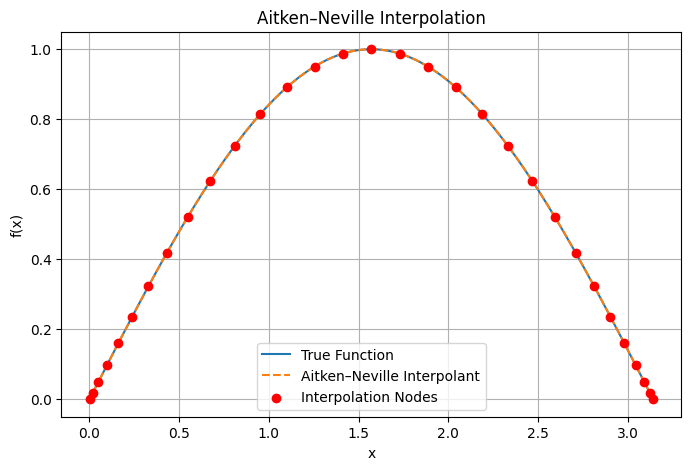

In [5]:
func = jnp.sin
# Chebyshev nodes in [0, pi]
n = 30
angles = jnp.pi * (2 * jnp.arange(n + 1) + 1) / (2 * (n + 1))
x_nodes = (jnp.cos(angles) + 1) * (jnp.pi / 2)

# Plot interpolation
plot_interpolation(func, x_nodes, x_range=(0.0, jnp.pi), num_eval=400)

## Evaluation
To benchmark against a "naive" implementation of Aitken Neville using for loops instead of JAX's JIT feature, we define it first.

In [ ]:
import numpy as np

def aitken_neville_naive(x_values, y_values, x):
    m = len(x_values)
    P = [[0.0]*m for _ in range(m)]
    for i in range(m):
        P[i][i] = y_values[i]
    for k in range(1, m):
        for i in range(m-k):
            j = i + k
            num = (x - x_values[i]) * P[i+1][j] \
                - (x - x_values[j]) * P[i][j-1]
            den = x_values[j] - x_values[i]
            P[i][j] = num / den
    return P[0][m-1]

# convert JAX nodes to np for the "naive" version
y_nodes = jax.vmap(func)(x_nodes)
x_vals_np = np.array(x_nodes)
y_vals_np = np.array(y_nodes)

Now we compare both versions...

In [ ]:
import time
import numpy as np
import jax.numpy as jnp

grid_sizes = [200, 1000, 2000, 5000, 10000]

print("   # evals    |   JAX (ms)   |  Naive (ms)")
print("------------------------------------------")

for n in grid_sizes:
    x_eval = jnp.linspace(0.0, jnp.pi, n)
    x_eval_np = np.array(x_eval)

    # warm up (JAX compile) on 1 point
    _ = aitken_neville(x_nodes, y_nodes, x_eval[:1]).block_until_ready()

    # time JAX
    t0 = time.perf_counter()
    _ = aitken_neville(x_nodes, y_nodes, x_eval).block_until_ready()
    t1 = time.perf_counter()
    jax_ms = (t1 - t0) * 1e3

    # time naive
    t2 = time.perf_counter()
    for xv in x_eval_np:
        _ = aitken_neville_naive(x_vals_np, y_vals_np, float(xv))
    t3 = time.perf_counter()
    naive_ms = (t3 - t2) * 1e3

    print(f"{n:10d}    |  {jax_ms:10.2f}  |  {naive_ms:10.2f}")


   # evals    |   JAX (ms)   |  Naive (ms)
------------------------------------------
       200    |        1.25  |       51.88
      1000    |        3.26  |      223.75
      2000    |        4.50  |      454.64
      5000    |       12.06  |     1110.83
     10000    |       40.66  |     2229.24
